# Pulsar Star Predictor

*Group 006-35: Rapeewit Chanprakaisi, Arav Dewan, Serena Khatwa, Mike Zhang*

## Introduction

A pulsar star is a highly magnetized rotating neutron star which emits electromagnetic radiation beams out of its magnetic poles. Electromagnetic waves produce a detectable pattern of broadband radio emission. However, detection of a pulsar in reality is challenging because radio frequency interferences and radio noise often trigger the detectors and mimic the pulsar star. In this project, we will answer the following question:

*Using our prediction model, how accurately can we predict whether or not a signal is from a pulsar star?*

We will be using the HTRU2 data set which contains pulsar candidates collected during the High Time Resolution Universe Survey to conduct our study. The HTRU2 dataset contains 17898 examples out of which 1639 are real pulsar examples. Each observation is described by 8 continuous variables, and a single class variable. The first 4 are mean, standard deviation, excess kurtosis, and skewness obtained from the integrated pulse profile, while the other 4 are from the DM-SNR curve.

## Methods & Results

In [1]:
# loading in libaries
install.packages("themis")
library(themis)
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: recipes

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ stringr::fixed() masks recipes::fixed()
✖ dplyr::lag()     masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials   

### Reading

In [2]:
# reading the data set from the web
pulsar_data <- read_csv("https://raw.githubusercontent.com/rchanpra/dsci100_group_project/main/HTRU2/HTRU_2.csv",
                        col_names = FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling

In [3]:
# adding column names
colnames(pulsar_data) <- c("mean_profile",
                           "deviation_profile",
                           "kurtosis_profile",
                           "skewness_profile",
                           "mean_curve",
                           "deviation_curve",
                           "kurtosis_curve",
                           "skewness_curve",
                           "class")

# renaming values and factoring the `class` variable
pulsar_data <- pulsar_data |>
    mutate(class = ifelse(class == 1, "pulsar", "non_pulsar")) |>
    mutate(class = as_factor(class))
pulsar_data |> head(6)

mean_profile,deviation_profile,kurtosis_profile,skewness_profile,mean_curve,deviation_curve,kurtosis_curve,skewness_curve,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,non_pulsar
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,non_pulsar
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,non_pulsar
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,non_pulsar
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,non_pulsar
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,non_pulsar


**Table 1**: Pulsar dataset

### Splitting

In [4]:
set.seed(2023)

# splitting the dataset into training and testing data
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

### Summarizing

In [5]:
# determining the number of rows that have missing data
pulsar_train |> is.na() |> sum()

[1] 0

In [6]:
# finding the mean of each continuous variables
pulsar_train |> select(!class) |> map_df(mean)

mean_profile,deviation_profile,kurtosis_profile,skewness_profile,mean_curve,deviation_curve,kurtosis_curve,skewness_curve
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
111.1715,46.57221,0.47494,1.751929,12.51202,26.28832,8.29349,104.3026


**Table 2**: Mean of each continuous variable in the pulsar training dataset

In [7]:
# finding the count of each value in class
pulsar_train |> group_by(class) |> summarize(n = n())

class,n
<fct>,<int>
non_pulsar,12195
pulsar,1228


**Table 3**: Count of each value in class in the pulsar training dataset

In [8]:
# alternatively, we can also use the `summary()` function
pulsar_train |> summary()

  mean_profile     deviation_profile kurtosis_profile  skewness_profile 
 Min.   :  5.812   Min.   :25.22     Min.   :-1.8760   Min.   :-1.7819  
 1st Qu.:100.855   1st Qu.:42.46     1st Qu.: 0.0267   1st Qu.:-0.1900  
 Median :115.141   Median :47.00     Median : 0.2238   Median : 0.1950  
 Mean   :111.171   Mean   :46.57     Mean   : 0.4749   Mean   : 1.7519  
 3rd Qu.:127.070   3rd Qu.:51.02     3rd Qu.: 0.4702   3rd Qu.: 0.9232  
 Max.   :192.617   Max.   :91.81     Max.   : 8.0695   Max.   :68.1016  
   mean_curve       deviation_curve  kurtosis_curve   skewness_curve    
 Min.   :  0.2132   Min.   :  7.37   Min.   :-2.812   Min.   :  -1.965  
 1st Qu.:  1.9293   1st Qu.: 14.49   1st Qu.: 5.731   1st Qu.:  34.366  
 Median :  2.8102   Median : 18.49   Median : 8.416   Median :  82.993  
 Mean   : 12.5120   Mean   : 26.29   Mean   : 8.293   Mean   : 104.303  
 3rd Qu.:  5.4916   3rd Qu.: 28.48   3rd Qu.:10.680   3rd Qu.: 138.690  
 Max.   :223.3921   Max.   :109.71   Max.   :34.540

**Table 4**: Summary of the pulsar training dataset

### Finding Predictor Variables

For the sake of simplicity, we will use 4 predictor variables from either the integrated pulse profile or the DM-SNR curve. We will capitalize on the `ggpairs()` function from the `GGally` library to plot the variables against each other with class as the color.

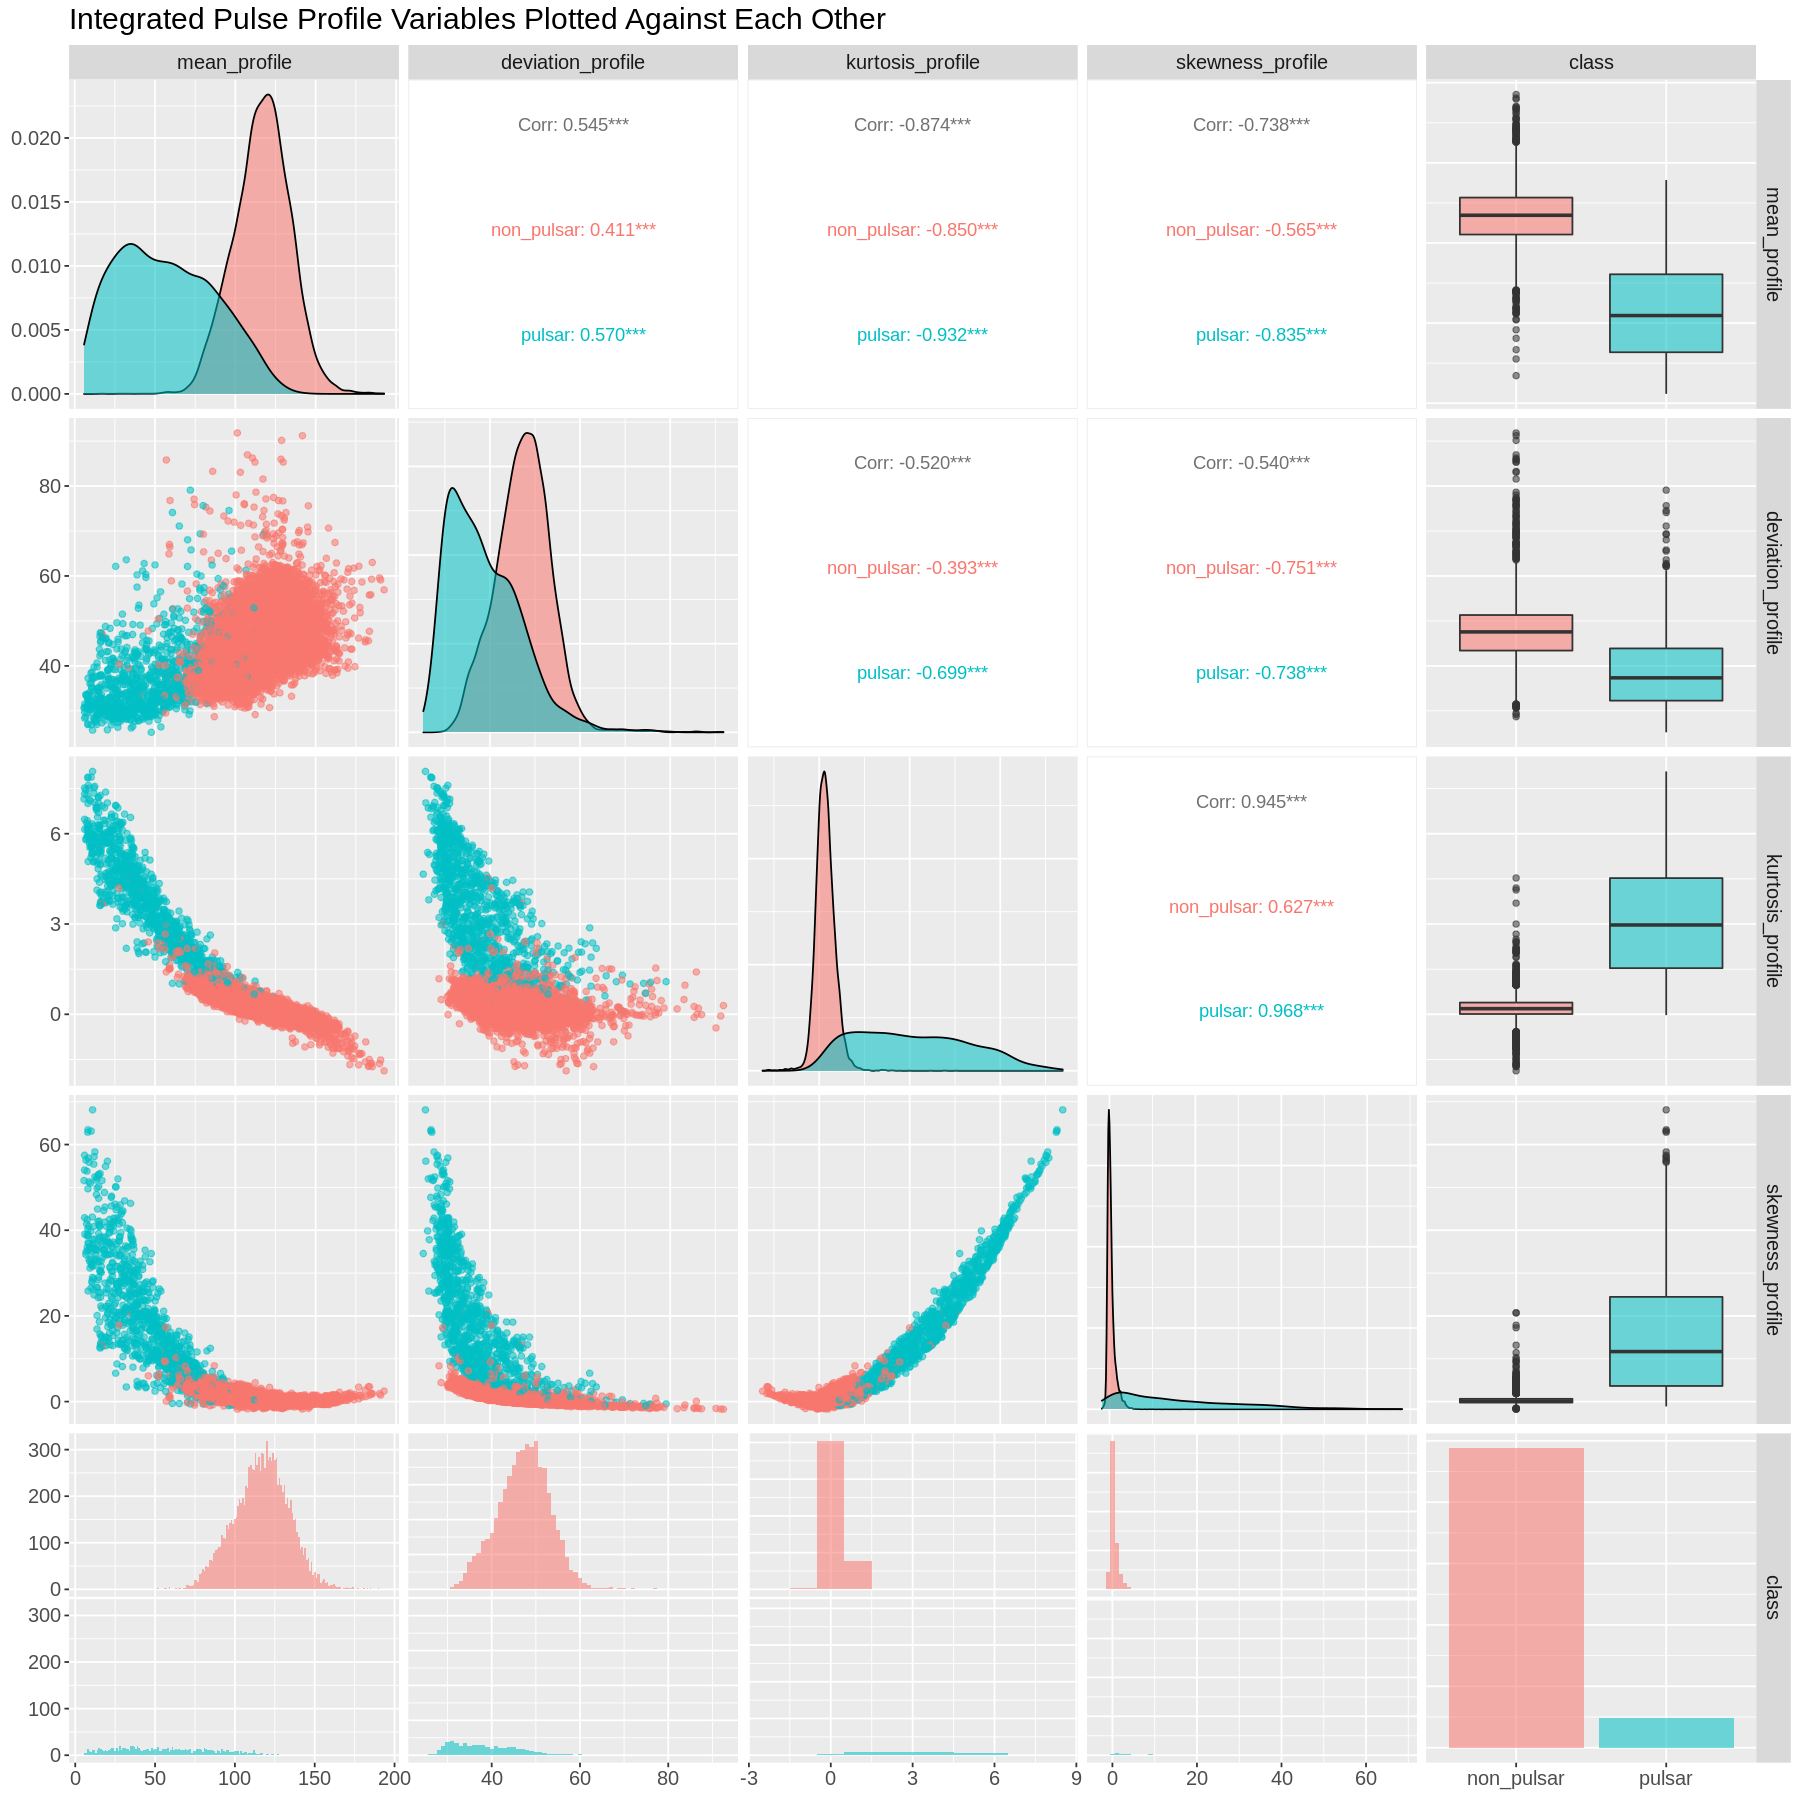

In [9]:
options(repr.plot.width = 15, repr.plot.height = 15)

# plotting profile variables against each other with class as color
pulsar_train_profile_plot <- pulsar_train |>
    select(!mean_curve:skewness_curve) |>
    ggpairs(aes(color = class, alpha = 0.5),
            lower = list(combo = wrap("facethist", binwidth = 1))) +
    labs(title = "Integrated Pulse Profile Variables Plotted Against Each Other") +
    theme(text = element_text(size = 15))
pulsar_train_profile_plot

**Figure 1**: Integrated pulse profile variables plotted against each other with the `ggpair()` function

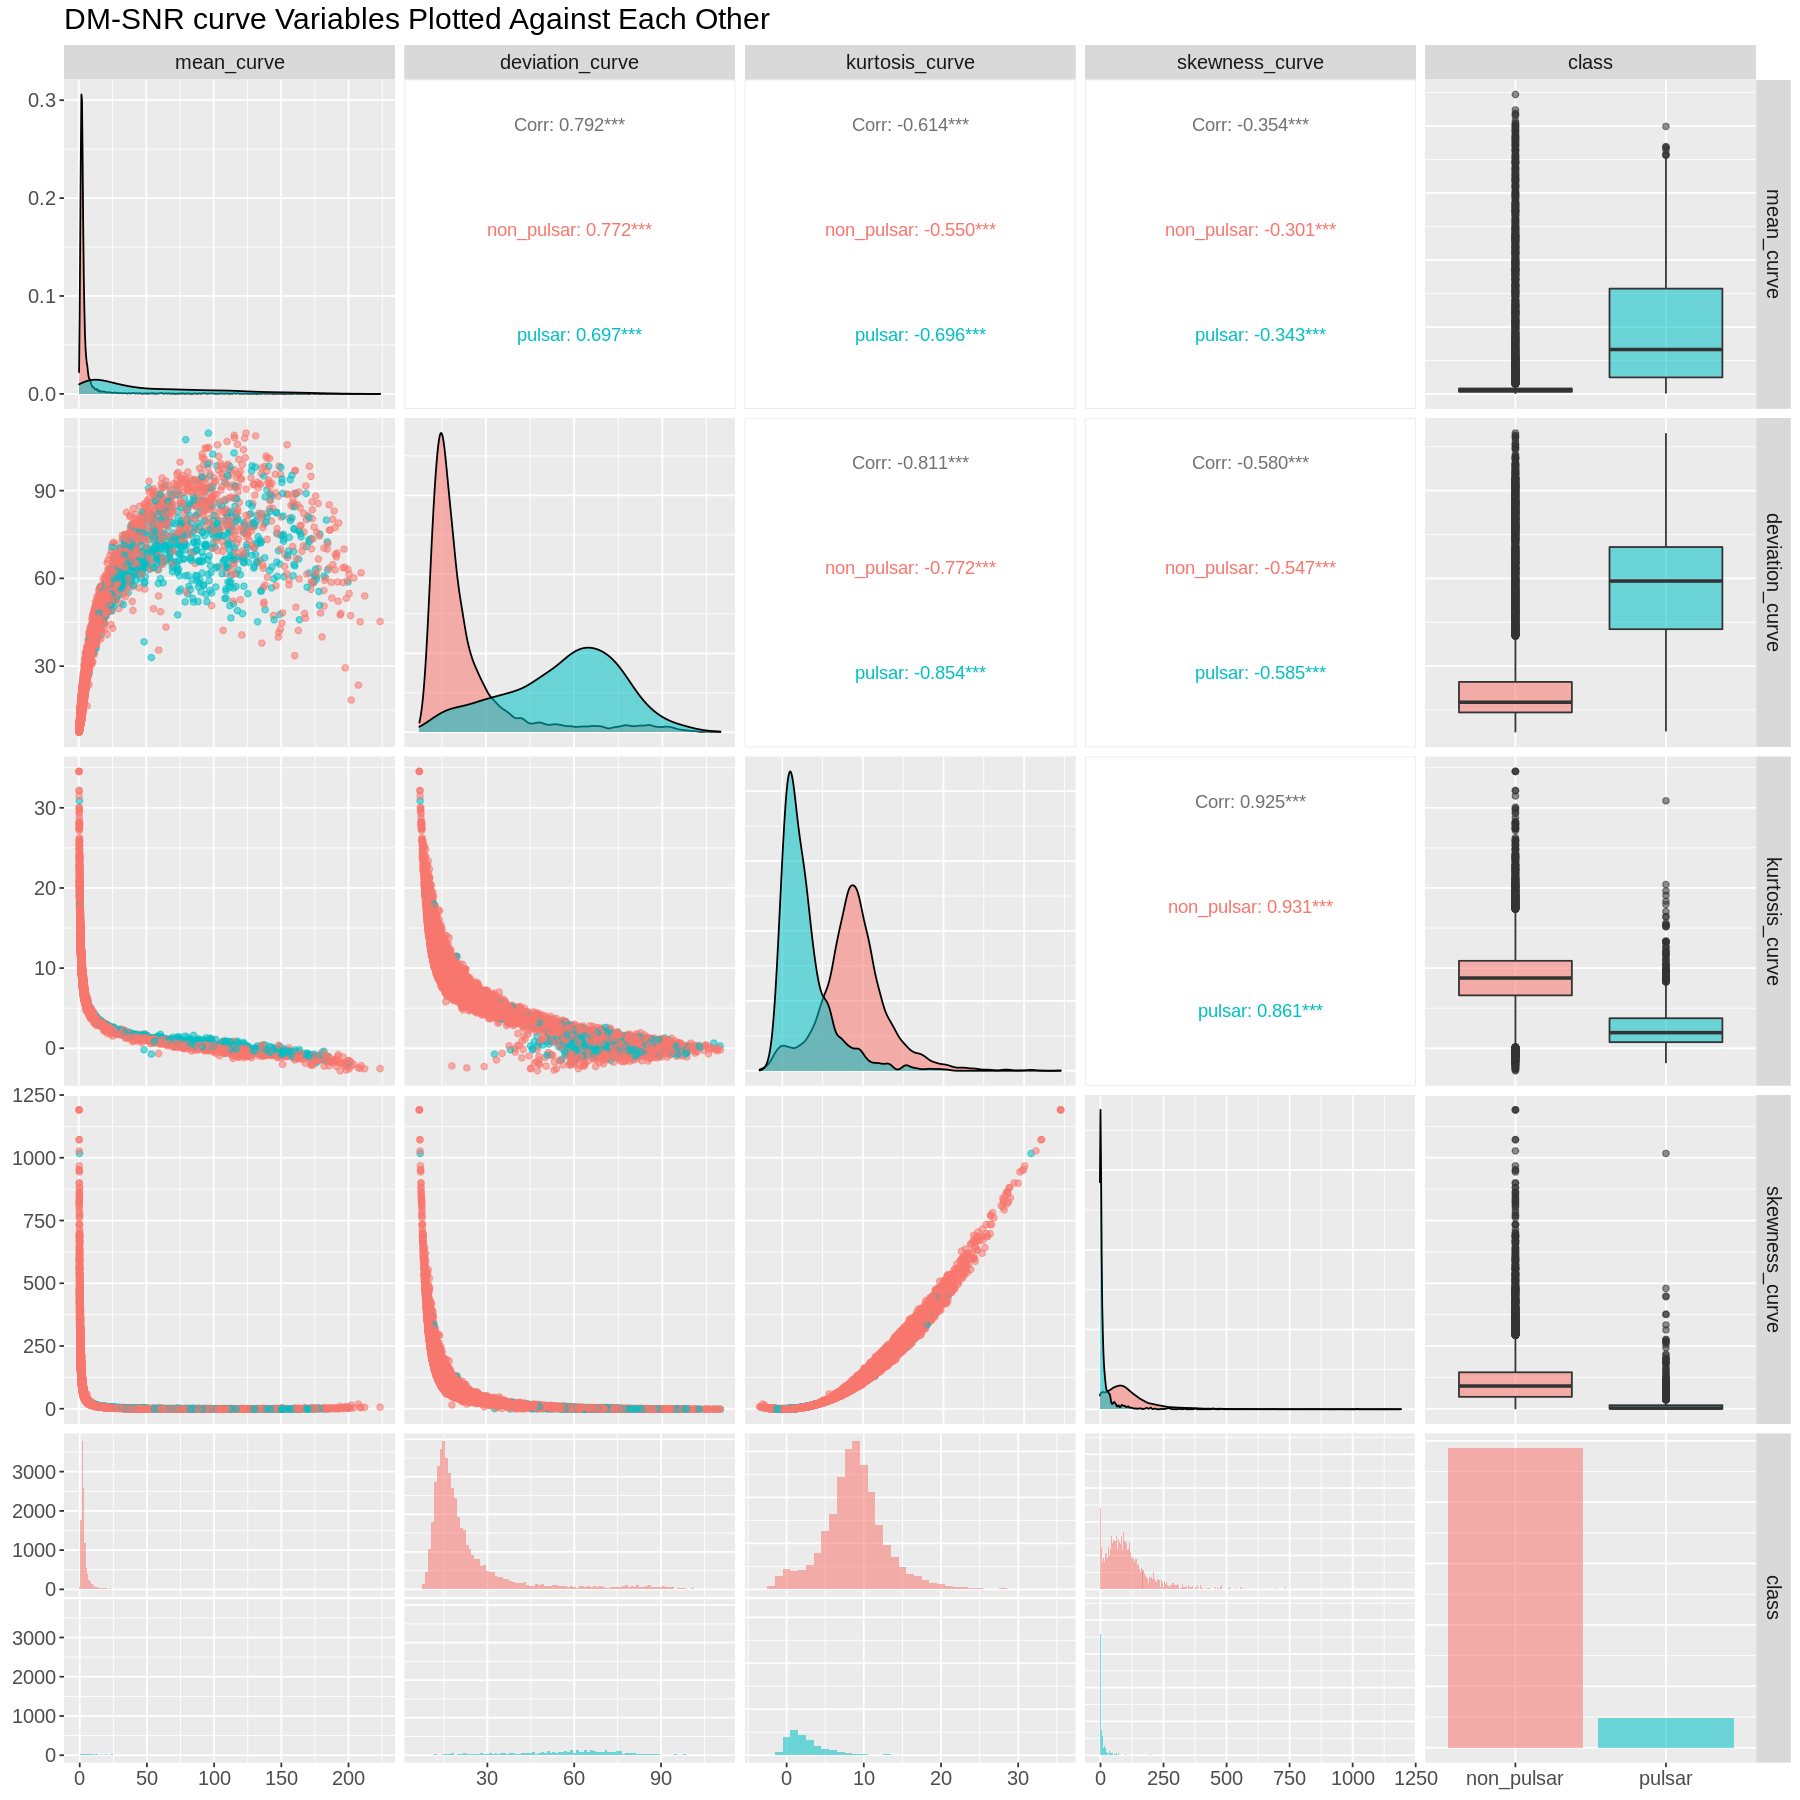

In [10]:
options(repr.plot.width = 15, repr.plot.height = 15)

# plotting dmsnr variables against each other with class as color
pulsar_train_curve_plot <- pulsar_train |>
    select(!mean_profile:skewness_profile) |>
    ggpairs(aes(color = class, alpha = 0.5),
            lower = list(combo = wrap("facethist", binwidth = 1))) +
    labs(title = "DM-SNR curve Variables Plotted Against Each Other") +
    theme(text = element_text(size = 15))
pulsar_train_curve_plot

**Figure 2**: DM-SNR curve variables plotted against each other with the `ggpair()` function

### Choosing Predictor Variables

When comparing box subplots at the most right column of the two ggpairs plot, we can see that the integrated pulse profile variables have boxes that are thicker and at more distinct levels. When comparing subplots at the most bottom row of the two ggpairs plot, we can see that the integrated pulse profile variables have pulsar observations more visible. When comparing the scatter plots of the variables against each other, we can see that the integrated pulse profile variables have a better separation of pulsar and non-pulsar than the DM-SNR curve variables

From the ggpairs plots above, we can conclude that the integrated pulse profile variables are better predictors than the DM-SNR curve variables. Therefore, we will use the 4 integrated pulse profile variables as our predictor variables.

After further researching about the parameters, the integrated pulse profile variables (`mean_profile`, `deviation_profile`, `kurtosis_profile`, and `skewness_profile`) have been considered to be essential in finding if a reading is a pulsar star or not (Lyon, 2016), which supports our choice for the predictor variables.

### Visualizing

In [11]:
# centering and scaling predictor variables
pulsar_train_scaled <- recipe(class ~ mean_profile +
                        deviation_profile + 
                        kurtosis_profile + 
                        skewness_profile, data = pulsar_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) |>
    prep() |>
    bake(pulsar_train)
pulsar_train_scaled |> head(6)

mean_profile,deviation_profile,kurtosis_profile,skewness_profile,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.1474779,1.33470797,-0.670652802,-0.4013552,non_pulsar
-0.3382447,1.80326142,-0.009094895,-0.3711403,non_pulsar
-0.3184188,-1.05916689,-0.143308166,-0.1147243,non_pulsar
0.9986311,1.55365398,-0.513596128,-0.3909742,non_pulsar
-0.8762891,-0.86425767,0.119029320,-0.1028834,non_pulsar
-0.6871805,0.01844365,0.053844970,-0.2185910,non_pulsar


**Table 5**: Scaled and centered pulsar training dataset

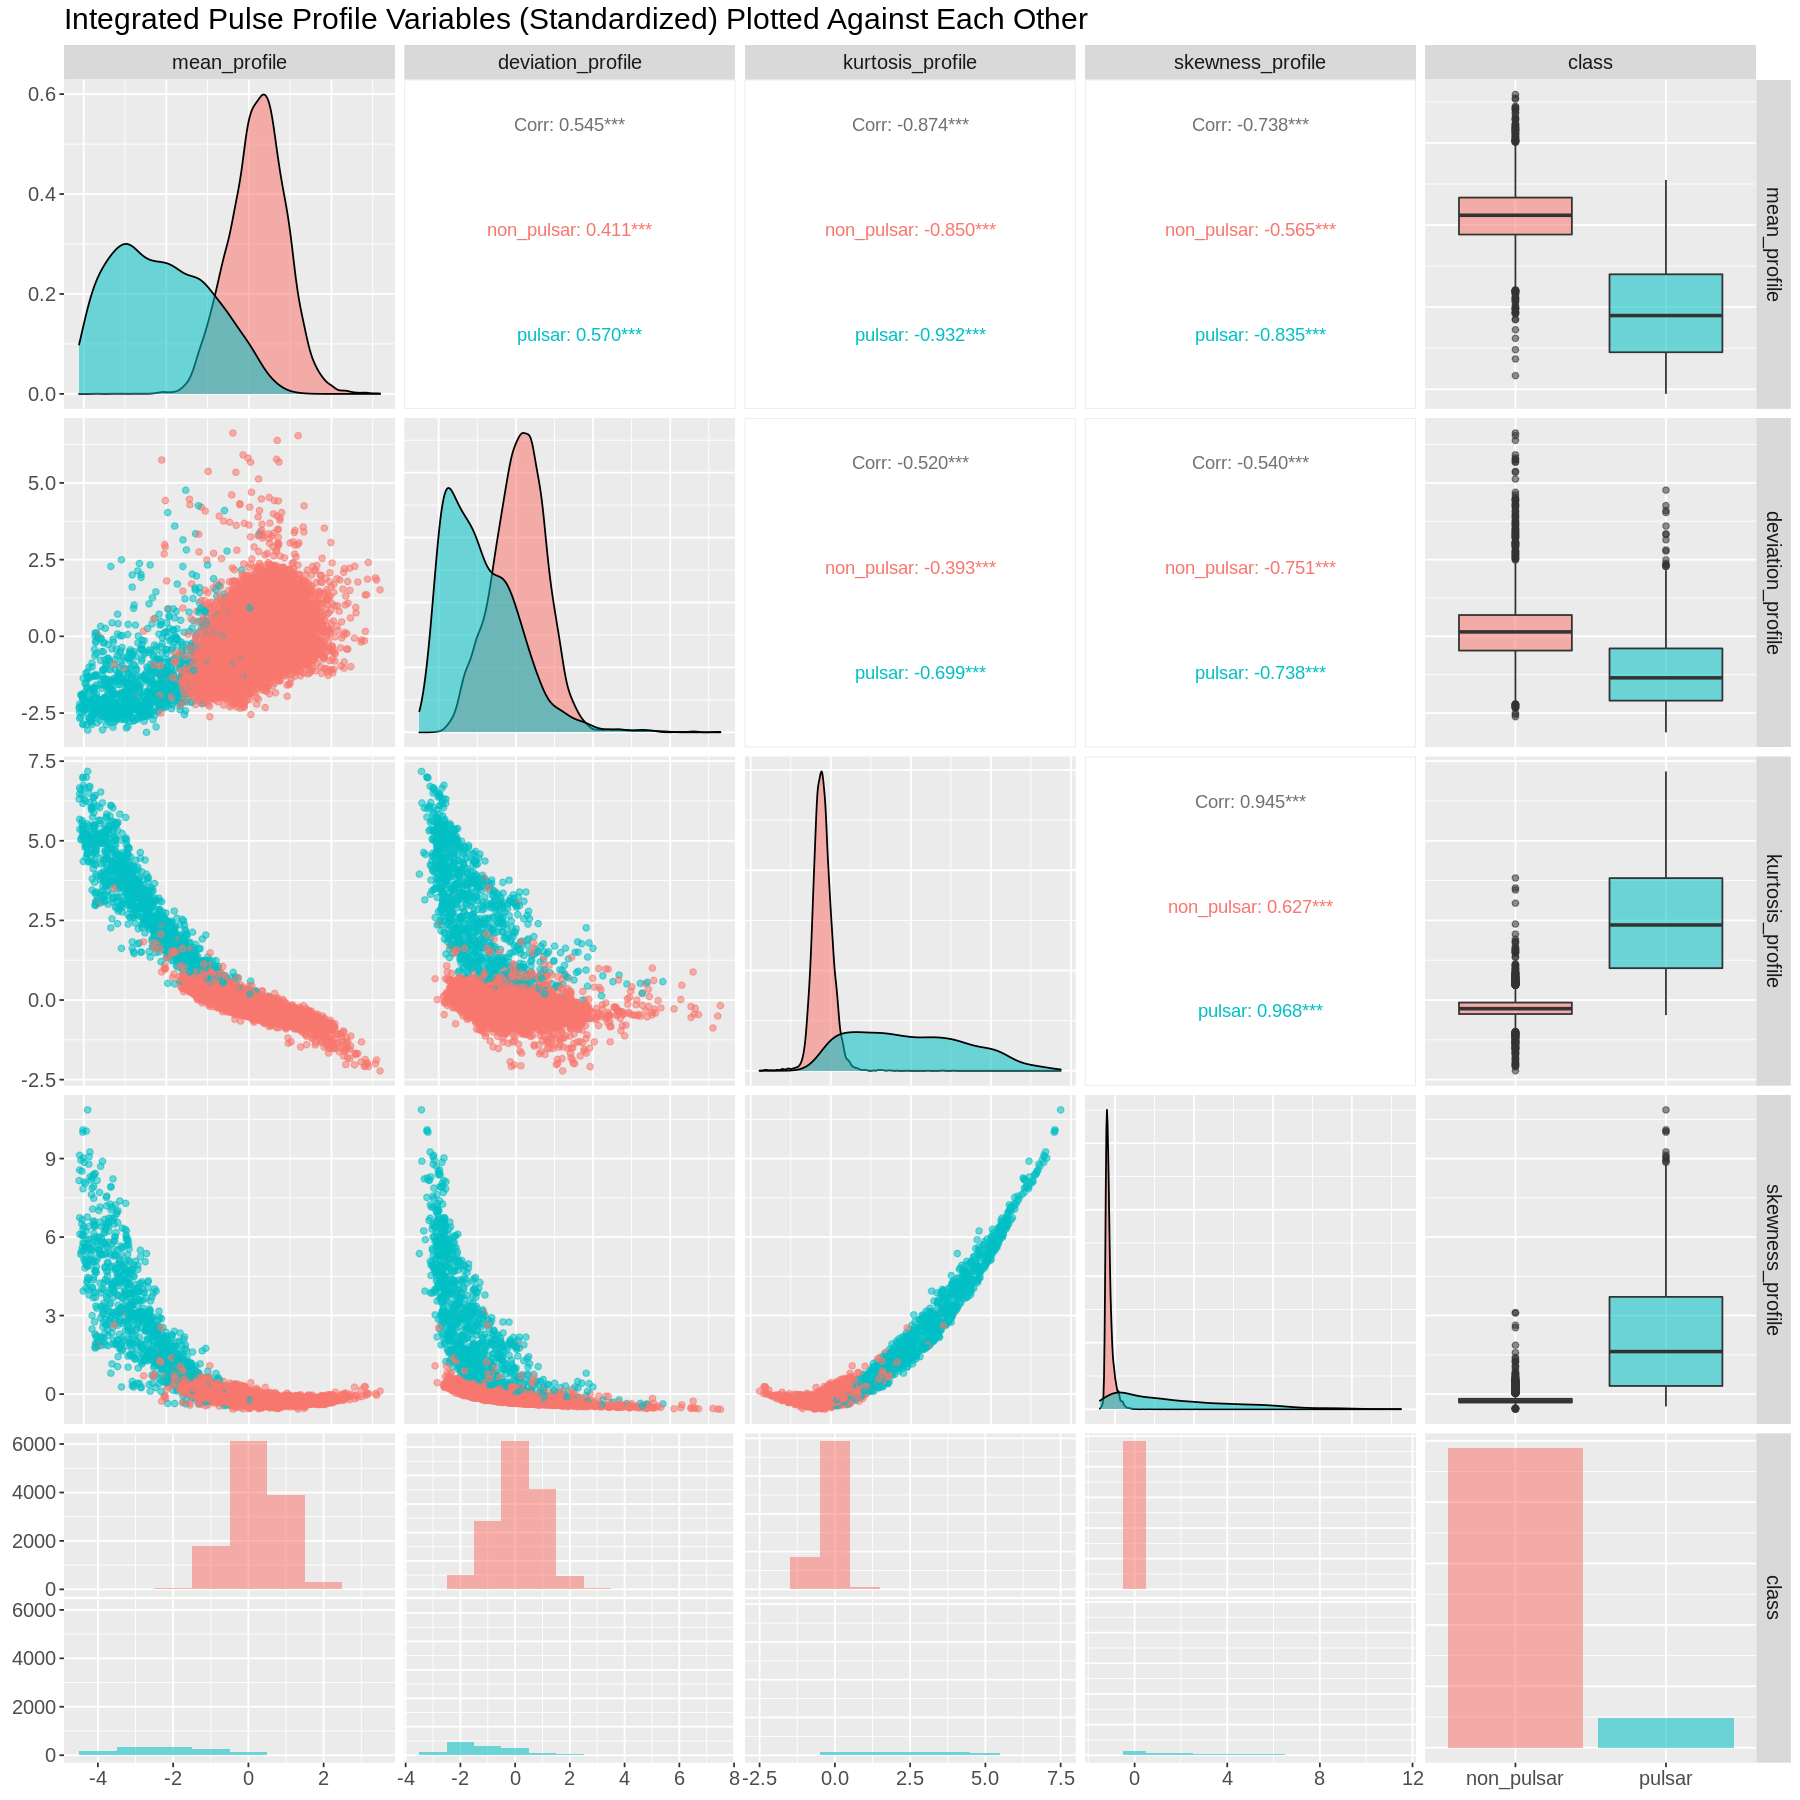

In [12]:
options(repr.plot.width = 15, repr.plot.height = 15)

# plotting scaled predictor variables against each other
pulsar_train_scaled_plot <- pulsar_train_scaled |>
    ggpairs(aes(color = class, alpha = 0.5),
            lower = list(combo = wrap("facethist", binwidth = 1))) +
    labs(title = "Integrated Pulse Profile Variables (Standardized) Plotted Against Each Other") +
    theme(text = element_text(size = 15))
pulsar_train_scaled_plot

**Figure 3**: Scaled and centered integrated pulse profile variables plotted against each other with the `ggpair()` function

### Classification Methods

The following 4 variables will be use as our predictor variables: `mean_profile`, `deviation_profile`, `kurtosis_profile`, and `skewness_profile`.

We will use the k-nearest neighbors classification algorithm to build the predictor model, which will be tuned and cross-validated to determine the best value of K to use for the model. The model will then be trained and tested to find its accuracy in predicting pulsar signals.

We are planning to visualize the results of the model by utilizing a scatter plot that is coloured with the correctness of the model for each observation. This will come with an accuracy percentage of the model.

### Performing Data Analysis

#### Tuning and Cross-validating to find best value of $k$

Since the pulsar data and the training data is unbalanced with a non-pulsar to pulsar ratio of roughly $10$ to $1$, we will be using the `step_upsample()` function from the `themis` library to balance our data.

We will also be doing a $5$-fold cross-validation with a range of values of $k$ from $1$ to $25$ to find the best value of $k$.

In [13]:
set.seed(2023)

# upsampling pulsar training data
pulsar_train_upsampled <- recipe(class ~ mean_profile + deviation_profile + kurtosis_profile + skewness_profile, data = pulsar_train) |>
    step_upsample(class, over_ratio = 1) |>
    prep() |>
    bake(pulsar_train)

# creating recipe with upsampled predictor variables
pulsar_recipe <- recipe(class ~ mean_profile + deviation_profile + kurtosis_profile + skewness_profile, data = pulsar_train_upsampled) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

# creating specification for classification tuning
pulsar_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# performing 5-fold cross validation
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

# gridvals
gridvals <- tibble(neighbors = seq(1, 25, 1))

# fitting tune model
tune_results <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(pulsar_tune) |>
    tune_grid(resamples = pulsar_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
tune_results |> arrange(desc(mean)) |> head(6)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.9783206,5,0.0009538706,Preprocessor1_Model15
16,accuracy,binary,0.9783206,5,0.0009538706,Preprocessor1_Model16
19,accuracy,binary,0.9782461,5,0.0009765113,Preprocessor1_Model19
20,accuracy,binary,0.9782461,5,0.0009765113,Preprocessor1_Model20
25,accuracy,binary,0.9782461,5,0.0012727642,Preprocessor1_Model25
21,accuracy,binary,0.9781716,5,0.0010906549,Preprocessor1_Model21


**Table 6**: Accuracy of different $k$ neighbours sorted by descending mean

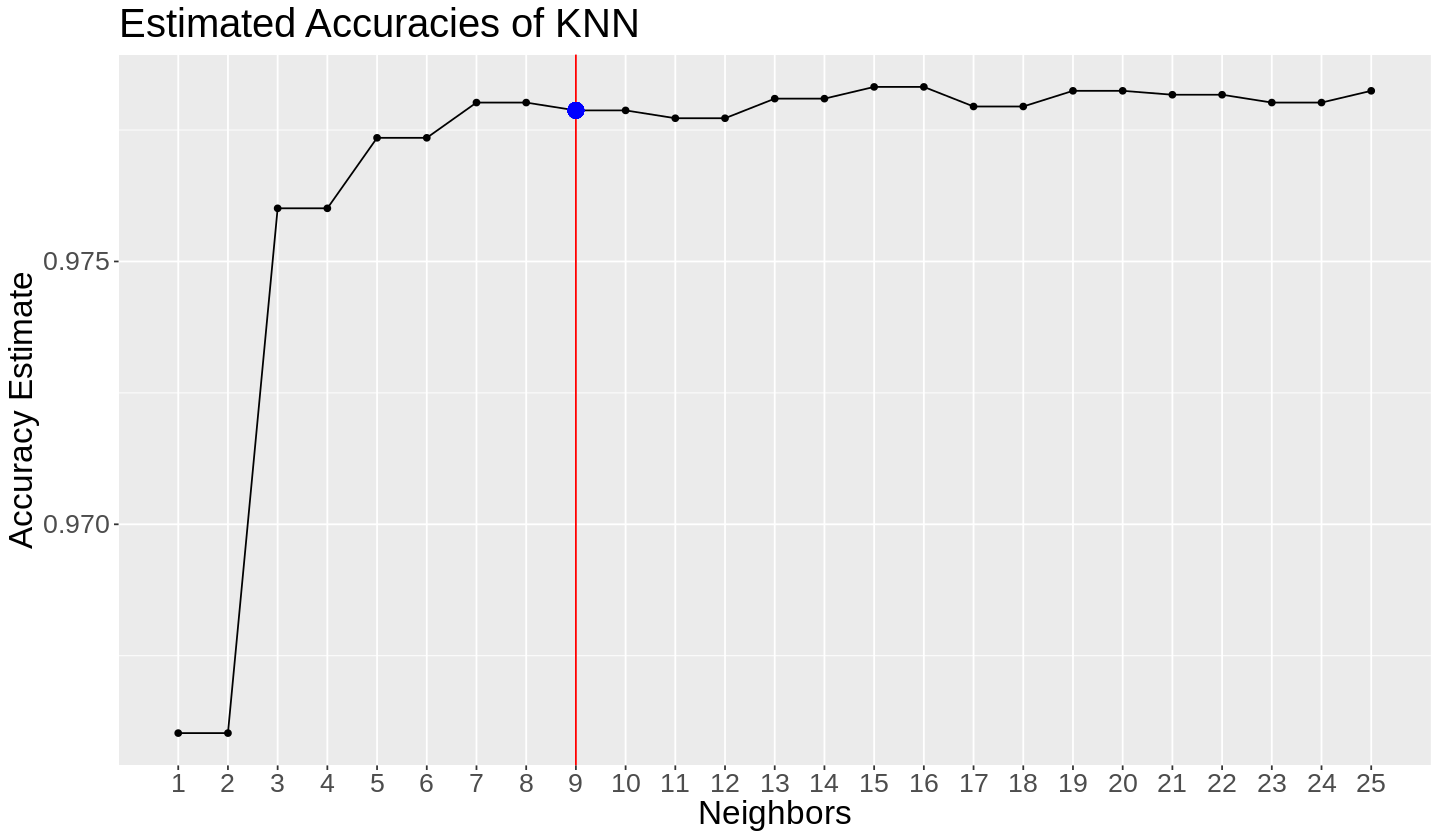

In [14]:
options(repr.plot.width = 12, repr.plot.height = 7)

# assigning best value of k to a value
best_k <- 9

# pulling the accuracy of the best value of k
best_ky <- tune_results |>
    filter(neighbors == best_k) |>
    select(mean) |>
    pull()

# plotting accuracy of knn
cross_val_plot <- ggplot(tune_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = best_k, colour = "red") +
    geom_point(aes(x = best_k, y = best_ky), size = 4, colour = "blue") +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Estimated Accuracies of KNN") +
    scale_x_continuous(limits = c(1, 25),
                       breaks = seq(1, 25, 1),
                       minor_breaks = seq(1, 25, 1)) +
    theme(text = element_text(size = 20))
cross_val_plot

**Figure 4**: Estimated Accuracies of KNN plot to determine best value of $k$

#### Selecting the best value of $k$

From the plot, we see that the accuracy estimate leverages at 9. Therefore, we will select $k = 9$ as the best value of $k$.

#### Fitting with the best value of $k$

In [15]:
set.seed(2023) 

# creating specification for classification tuning with best value of k
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# fitting best K model
pulsar_fit <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(pulsar_spec) |>
    fit(data = pulsar_train)

# binding predictions from predictor model
pulsar_predictions <- predict(pulsar_fit, pulsar_test) |>
    bind_cols(pulsar_test)
pulsar_predictions |> head(6)

.pred_class,mean_profile,deviation_profile,kurtosis_profile,skewness_profile,mean_curve,deviation_curve,kurtosis_curve,skewness_curve,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
non_pulsar,130.38281,39.84406,-0.1583228,0.3895404,1.220736,14.37894,13.539456,198.23646,non_pulsar
non_pulsar,107.25781,39.49649,0.4658820,1.1628771,4.079431,24.98042,7.397080,57.78474,non_pulsar
non_pulsar,134.96094,49.55433,-0.1353038,-0.0804696,10.696488,41.34204,3.893934,14.13121,non_pulsar
pulsar,99.36719,41.57220,1.5471970,4.1541060,27.555184,61.71902,2.208808,3.66268,pulsar
non_pulsar,95.86719,42.05992,0.3263869,0.8035018,1.832776,12.24897,11.249331,177.23077,non_pulsar
non_pulsar,117.36719,53.90861,0.2579534,-0.4050491,6.018395,24.76612,4.807783,25.52262,non_pulsar


**Table 7**: Pulsar testing dataset with predictions from the predictor model binded

In [16]:
# finding accuracy of predictions from predictor model
pulsar_metrics <- pulsar_predictions |>
    metrics(truth = class, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1)
pulsar_metrics

.metric,.estimate
<chr>,<dbl>
accuracy,0.9792179


**Table 8**: Accuracy of the predictions from the predictor model

In [17]:
# creating a confusion matrix for predictions from predictor model
pulsar_matrix <- pulsar_predictions |>
    conf_mat(truth = class, estimate = .pred_class)
pulsar_matrix

            Truth
Prediction   non_pulsar pulsar
  non_pulsar       4036     65
  pulsar             28    346

**Table 9**: Confusion matrix of the predictions from predictor model

#### Outcome of Analysis

The predictor model has an accuracy of ~$97.9$%.

### Analysis Visualizing the Analysis

Although `mean_profile` is not continuous, we choose to still use a histogram plot to visualize the accuracy of the predictions form the predictor model.

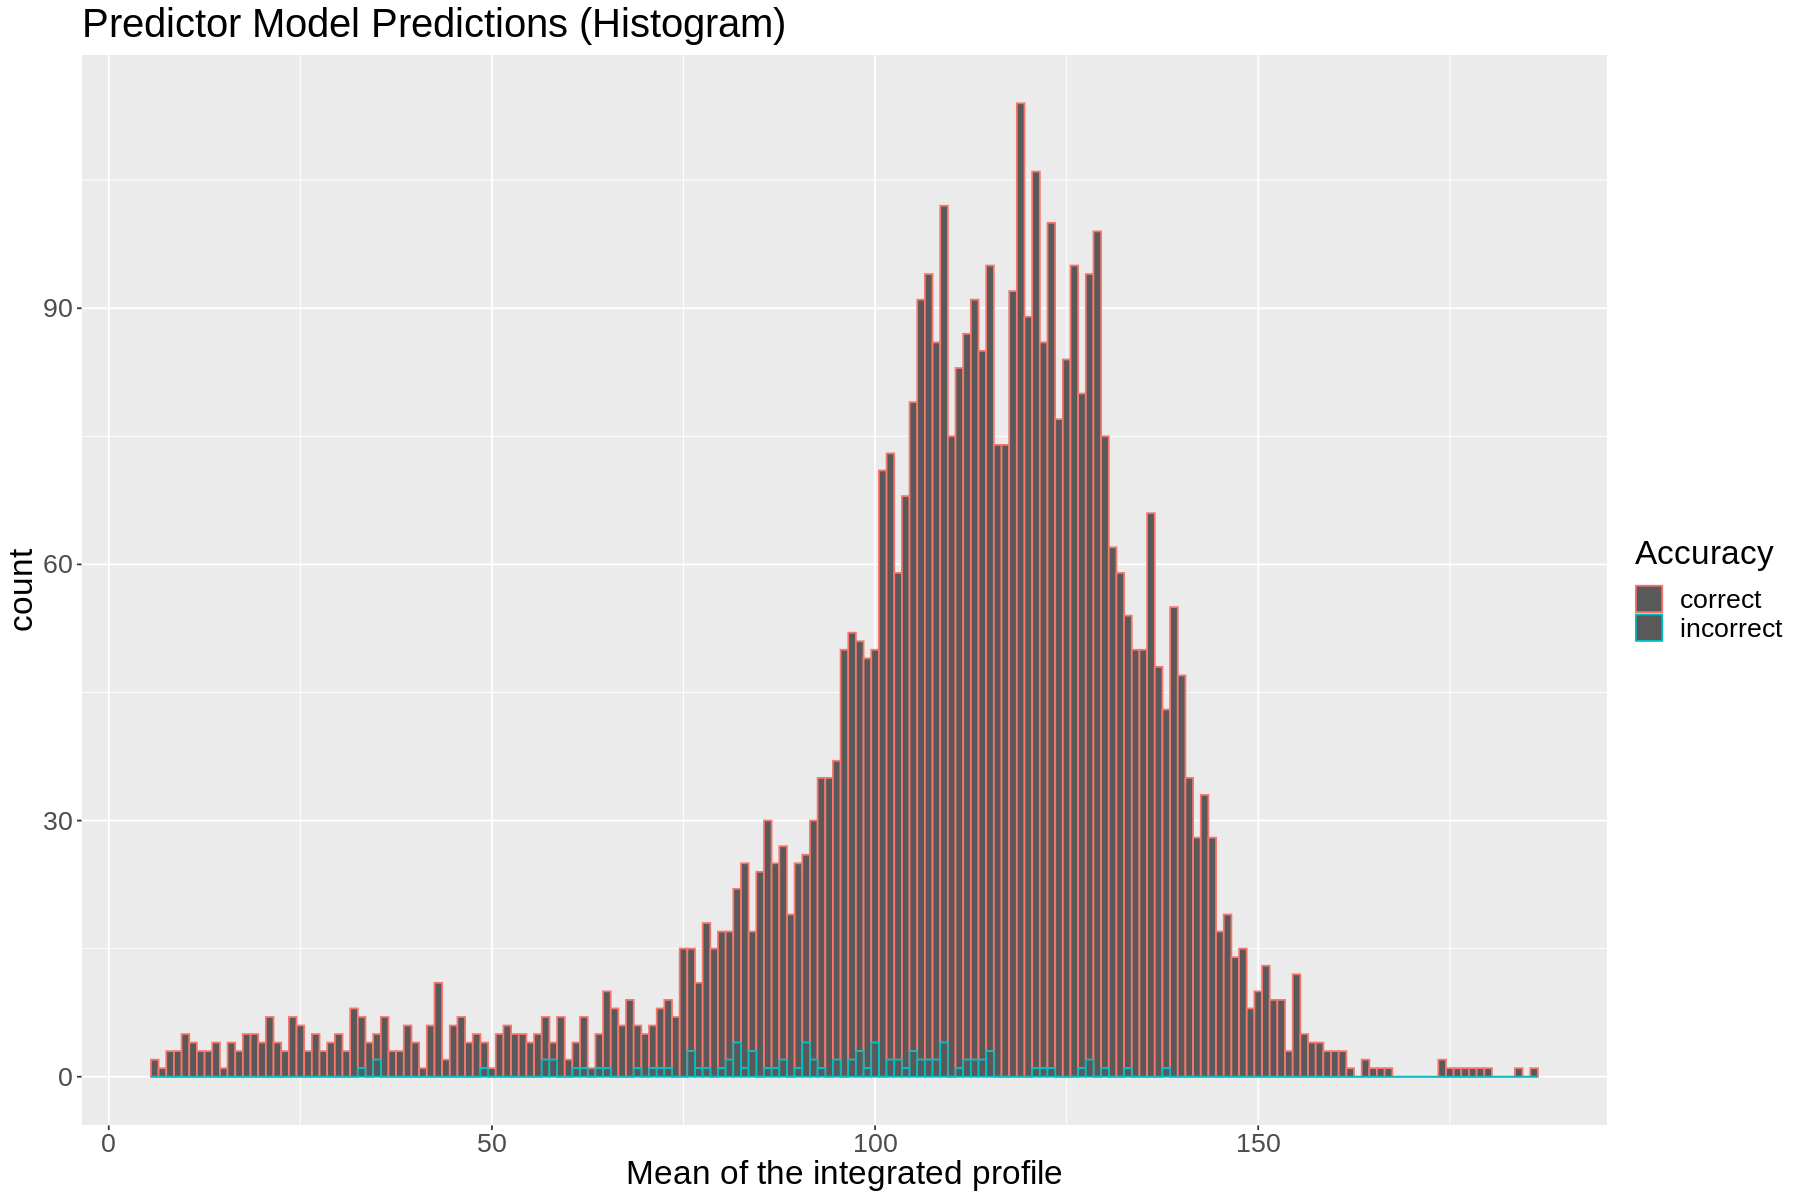

In [18]:
options(repr.plot.width = 15, repr.plot.height = 10)

# plotting predictor model predictions as a histogram plot
pulsar_histogram <- pulsar_predictions |>
    mutate(accuracy = ifelse(.pred_class == class, "correct", "incorrect")) |>
    ggplot(aes(x = mean_profile, colour = accuracy)) +
    geom_histogram(binwidth = 1) +
    labs(x = "Mean of the integrated profile", colour = "Accuracy", title = "Predictor Model Predictions (Histogram)") +
    theme(text = element_text(size = 20))
pulsar_histogram

**Figure 5**: Histogram plots for the predictor model predictions

## Discussion

### Summary of finding
The classification model allowed us to accurately predict if data collected by our receivers is from a pulsar star or not. By using mean_profile, deviation_profile, kurtosis_profile, and skewness_profile, we were able to achieve a high accuracy of 94%. To use the optimum neighbors to make predictions with neither overfitting nor underfitting the model, we applied the method of cross-validation to check the accuracy of all the values of k, to find the most suitable one. We found the optimum value of k-nearest neighbors to be 15 by using 5-fold cross-validation. 
It is also important to note that as the given data set was quite disproportionate, we also had to employ the method of up-sampling our data to reduce any bias that may occur due to the uneven dataset.

### Possible improvements
Although the accuracy of our model is quite impressive, we believe that by using even more predictors, we can potentially create an even better model that can decrease any false predictions even further. That will be a significant step as pulsar stars are not very common and are a rather rare detection, this increase in the accuracy of a model will be a turning point in the scientific research about these stars. Nonetheless, our model will still be of scientific importance in pulsar star identification.

### Findings and prior expectations
...

### Impact of findings
As mentioned earlier, pulsar stars are simply pulsating neutron stars, which rotate round their axes to emit high-frequency radio signals. We do not know much about neutron stars but scientific research so far hypotheses that  neutron star collisions are the main source of many heavy elements such as Uranium and Gold in our universe . A neutron star is a prime research topic and scientists get to know more about these neutron stars through their pulses. And our model can be utilized in predicting which signal is from a neutron star so that further research and resources could be invested in uncovering more about this phenomenon.

### Future questions
A neutron star relays information through the pulses that we are using to detect its class. So far, our model is only able to detect if a reading received is from a pulsar star or not. But we could potentially use this very data along with many other predictors to not only detect the presence of a pulsar star but also predict the characteristic features of that star. What if we could find the size, mass, age and many other things with our model?

## References

R. J. Lyon, HTRU2, DOI: 10.6084/m9.figshare.3080389.v1.

R. J. Lyon, 'Why Are Pulsars Hard To Find?', PhD Thesis, University of Manchester, 2016.

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

Lea. R. 2023. What are pulsars? Space.com. https://www.space.com/32661-pulsars.html